Let's infer the HMDB-51 data using the I3D network.  

First, we want to download the pre-trained weights from the [MODEL_ZOO.md](https://github.com/kiyoon/PyVideoAI/blob/master/docs/MODEL_ZOO.md)  
We'll use the I3D pretrained on the HMDB-51 dataset, with 8-frame input.  

Note that the path to the pretrained weights is defined in `model_configs/i3d_resnet50.py` as below.  

```python
hmdb_pretrained_path_8x8 = os.path.join(DATA_DIR, 'pretrained', 'hmdb/i3d_resnet50/crop224_lr0001_batch8_8x8_largejit_plateau_1scrop5tcrop_split1-epoch_0199.pth')
```

In [1]:
## IMPORTANT: You must change path values in `00-storage_location.py` before executing below.
# Environments for future use

from pyvideoai.config import PYVIDEOAI_DIR, DATA_DIR
%env PYVIDEOAI_DIR=$PYVIDEOAI_DIR
%env DATA_DIR=$DATA_DIR

import os
exec(open(os.path.join(PYVIDEOAI_DIR, 'examples', '00-storage_location.py')).read())
%env HDD_PATH=$HDD_PATH

env: PYVIDEOAI_DIR=/home/kiyoon/project/PyVideoAI
env: DATA_DIR=/home/kiyoon/project/PyVideoAI/data
env: HDD_PATH=/mnt/hdd/kiyoon


In [2]:
# Link the pretrained weight directory to HDD
!mkdir -p "$HDD_PATH/pretrained/hmdb/i3d_resnet50"
!ln -s "$HDD_PATH/pretrained" "$DATA_DIR/"

# Download
!wget 'https://uoe-my.sharepoint.com/:u:/g/personal/s1884147_ed_ac_uk/EefmKjHu_iRPvN2JTqG2QNYBoCs18kbX0ajidiKOuWEgZQ?e=9oGJ0v&download=1' -O "$DATA_DIR/pretrained/hmdb/i3d_resnet50/crop224_lr0001_batch8_8x8_largejit_plateau_1scrop5tcrop_split1-epoch_0199.pth"

--2022-08-19 16:33:20--  https://uoe-my.sharepoint.com/:u:/g/personal/s1884147_ed_ac_uk/EefmKjHu_iRPvN2JTqG2QNYBoCs18kbX0ajidiKOuWEgZQ?e=9oGJ0v&download=1
Resolving uoe-my.sharepoint.com (uoe-my.sharepoint.com)... 13.107.136.9, 13.107.138.9
Connecting to uoe-my.sharepoint.com (uoe-my.sharepoint.com)|13.107.136.9|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/s1884147_ed_ac_uk/Documents/share/UniversityOfEdinburgh/PyVideoAI/model_zoo/hmdb/i3d_resnet50/hmdb-i3d_resnet50-crop224_lr0001_batch8_8x8_largejit_plateau_1scrop5tcrop_split1-epoch_0199.pth?ga=1 [following]
--2022-08-19 16:33:20--  https://uoe-my.sharepoint.com/personal/s1884147_ed_ac_uk/Documents/share/UniversityOfEdinburgh/PyVideoAI/model_zoo/hmdb/i3d_resnet50/hmdb-i3d_resnet50-crop224_lr0001_batch8_8x8_largejit_plateau_1scrop5tcrop_split1-epoch_0199.pth?ga=1
Reusing existing connection to uoe-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 219013464 (209M) [

Now we have our datasets processed, and the pretrained weights ready.  
We want to use three config files.  
- `hmdb.py` in `dataset_configs`,  
- `i3d_resnet50.py` in `model_configs`,  
- `hmdb/i3d_resnet50-crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained.py` in `exp_configs/ch_inference`.

In [9]:
# If you have more than 1 GPUs, go ahead and change CUDA_VISIBLE_DEVICES to the comma-separated GPU indices, and the second parameter of the `run_singlenode.sh` to the number of GPUs.
# This will increase the batch size (1 GPU=size 8, 2 GPU=size 16, ...) and speed up the evaluation process.
# However, Jupyter Notebook doesn't support multi-GPU training. Try using normal shell.

# -p will save the predictions into a pickle file.
# Adding `-m multicrop` will make it perform multicrop evaluation.
# `-c:e inference` indicates that the exp_config file is located in `ch_inference` directory.
%env CUDA_VISIBLE_DEVICES=0
!"$PYVIDEOAI_DIR/tools/run_singlenode.sh" eval 1 -D hmdb -M i3d_resnet50 -E crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained -c:e inference -p

env: CUDA_VISIBLE_DEVICES=0
pyvideoai.eval_multiprocess:   78 - INFO - PyTorch==1.10.1
pyvideoai.eval_multiprocess:   79 - INFO - PyVideoAI==v0.3+236.g4034acb.dirty
pyvideoai.eval_multiprocess:   80 - INFO - Experiment folder: /mnt/hdd/kiyoon/PyVideoAI_experiments/hmdb/i3d_resnet50/crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained/version_000 on host rossum
pyvideoai.eval_multiprocess:  111 - INFO - args: {
    "experiment_root": "/mnt/hdd/kiyoon/PyVideoAI_experiments",
    "dataset": "hmdb",
    "model": "i3d_resnet50",
    "experiment_name": "crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained",
    "subfolder_name": null,
    "dataset_channel": null,
    "model_channel": null,
    "experiment_channel": "inference",
    "load_epoch": null,
    "seed": 12,
    "mode": "oneclip",
    "split": null,
    "save_predictions": true,
    "dataloader_num_workers": 4,
    "telegram_bot_idx": 0,
    "refresh_period": 1,
    "version": "auto",
    "console_log_level": "INFO",
    "wandb": false,
    "wand

# What to do with the saved predictions
Many tools provided in the framework allows you to analyse performance using the saved predictions.  
We list some examples below.

## Loading the predictions (as raw data)
Sometimes you want to load the raw predictions and run your own code to analyse.  
Here's how to load the pickled predictions.

In [13]:
from pyvideoai.config import DEFAULT_EXPERIMENT_ROOT
from experiment_utils.experiment_builder import ExperimentBuilder
import os
import pickle

DATASET = 'hmdb'
MODEL = 'i3d_resnet50'
EXP_NAME = 'crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained'
import exp_configs
cfg = exp_configs.load_cfg(DATASET, MODEL, EXP_NAME, exp_channel = 'inference')
metrics = cfg.dataset_cfg.task.get_metrics(cfg)

# ExperimentBuilder quickly navigates you to the correct directory path of the experiment
summary_fieldnames, summary_fieldtypes = ExperimentBuilder.return_fields_from_metrics(metrics)
exp = ExperimentBuilder(DEFAULT_EXPERIMENT_ROOT, DATASET, MODEL, EXP_NAME, None, 
                        summary_fieldnames = summary_fieldnames, summary_fieldtypes = summary_fieldtypes)
predictions_path = os.path.join(exp.predictions_dir, 'pretrained_val_oneclip.pkl')
print(f'Predictions file path: {predictions_path}')

with open(predictions_path, 'rb') as f:
    predictions = pickle.load(f)

# Predictions are saved as dictionary of numpy arrays
print(f"Shape of video_ids (NUM_VAL_SAMPLES,): {predictions['video_ids'].shape}")
print(f"Shape of video_labels (NUM_VAL_SAMPLES,): {predictions['video_labels'].shape}")
print(f"Shape of video_predictions (NUM_VAL_SAMPLES, NUM_CLASSES): {predictions['video_predictions'].shape}")

Predictions file path: /mnt/hdd/kiyoon/PyVideoAI_experiments/hmdb/i3d_resnet50/crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained/version_000/predictions/pretrained_val_oneclip.pkl
Shape of video_ids (NUM_VAL_SAMPLES,): (1530,)
Shape of video_labels (NUM_VAL_SAMPLES,): (1530,)
Shape of video_predictions (NUM_VAL_SAMPLES, NUM_CLASSES): (1530, 51)


## Evaluate accuracy again using the saved predictions

We can use the `exp_configs`' `metrics` dictionary.

In [25]:
# Load experiment configs.
import exp_configs
import torch
cfg = exp_configs.load_cfg(DATASET, MODEL, EXP_NAME, exp_channel = 'inference')
metrics = cfg.dataset_cfg.task.get_metrics(cfg)  # This will return cfg.metrics if defined, otherwise the default one which is accuracy.

for metric in metrics['val']:
    metric.clean_data()
    metric.activation = None  # In our case, the predictions include activation already. Be careful not to apply twice.
    metric.add_clip_predictions(torch.tensor(predictions['video_ids']), torch.tensor(predictions['video_predictions']), torch.tensor(predictions['video_labels']))
    metric.calculate_metrics()
    print(metric.last_calculated_metrics)  # In our case, it will print top1 and top5 accuracy.

pyvideoai.tasks.task:   41 - INFO - cfg.last_activation not defined. Using softmax


(0.7032679915428162, 0.9313725233078003)


## Per-class accuracy and confusion matrix

Running the code below will generate confusion matrices of various sorting methods and shrinking classes with few validation examples.  
It will save as CSV, image (PNG & PDF) formats, and to the TensorBoard.

In [26]:
# No GPU required
%env CUDA_VISIBLE_DEVICES=
%run "$PYVIDEOAI_DIR/tools/visualisations/generate_confusion_matrix.py" -D hmdb -M i3d_resnet50 -E crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained -c:e inference

pyvideoai.tasks.task:   41 - INFO - cfg.last_activation not defined. Using softmax
experiment_utils.experiment_builder:  197 - INFO - Telegram bot not initialised.
__main__:  283 - INFO - train_class_frequency


env: CUDA_VISIBLE_DEVICES=


__main__:  193 - INFO - Saving confusion matrix to /mnt/hdd/kiyoon/PyVideoAI_experiments/hmdb/i3d_resnet50/crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained/version_000/plots/per_class_accuracy/sort_train_class_frequency
__main__:  198 - INFO - Saving confusion matrix to TensorBoard tagged sort_train_class_frequency
__main__:  283 - INFO - val_class_frequency
__main__:  193 - INFO - Saving confusion matrix to /mnt/hdd/kiyoon/PyVideoAI_experiments/hmdb/i3d_resnet50/crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained/version_000/plots/per_class_accuracy/sort_val_class_frequency
__main__:  198 - INFO - Saving confusion matrix to TensorBoard tagged sort_val_class_frequency
__main__:  283 - INFO - val_per_class_accuracy
__main__:  193 - INFO - Saving confusion matrix to /mnt/hdd/kiyoon/PyVideoAI_experiments/hmdb/i3d_resnet50/crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained/version_000/plots/per_class_accuracy/sort_val_per_class_accuracy
__main__:  198 - INFO - Saving confusion matrix to TensorBoard tagg

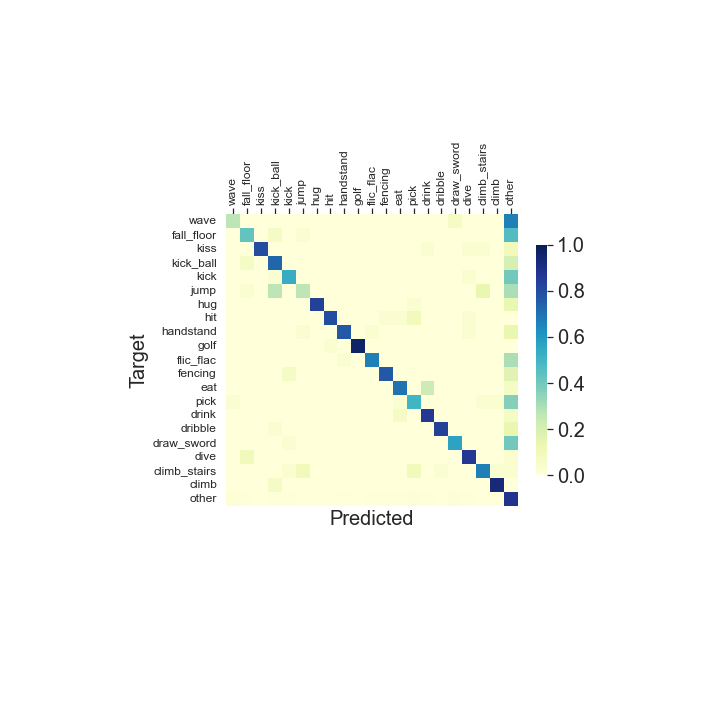

In [27]:
# Preview confusion matrix
png_path = os.path.join(exp.plots_dir, 'per_class_accuracy', 'sort_train_class_frequency', 'shrinked_confusion.png')
from IPython.display import Image
Image(filename=png_path)

In [28]:
# Preview per_class_accuracy.csv
csv_path = os.path.join(exp.plots_dir, 'per_class_accuracy', 'sort_train_class_frequency', 'shrinked_per_class_accuracy.csv')

!head -10 "$csv_path"

class_key,accuracy (%),num_correct_pred,num_samples_in_val,num_samples_in_train
wave,26.666666666666668,8,30,70
fall_floor,43.333333333333336,13,30,70
kiss,80.0,24,30,70
kick_ball,73.33333333333333,22,30,70
kick,53.333333333333336,16,30,70
jump,26.666666666666668,8,30,70
hug,83.33333333333334,25,30,70
hit,80.0,24,30,70
handstand,76.66666666666667,23,30,70


# TensorBoard visualisation
## Model graph
<img src="https://user-images.githubusercontent.com/12980409/122774410-1e708880-d2e4-11eb-89db-eafcd44cdb66.png" alt="TensorBoard model graph" width="400">

## Dataloader
You can also view the dataloader output (or, input to the model) on TensorBoard.

<img src="https://user-images.githubusercontent.com/12980409/122775048-b53d4500-d2e4-11eb-8fbf-d026b4d5d5bb.png" alt="TensorBoard dataloader visualisation" width="600">

In [34]:
# No GPU required
%env CUDA_VISIBLE_DEVICES=
# Add --jpgs to visualise as series of JPEGs. Otherwise, visualise as animated GIF.
%run "$PYVIDEOAI_DIR/tools/visualisations/model_and_dataloader_visualiser.py" -D hmdb -M i3d_resnet50 -E crop224_8x8_1scrop5tcrop_hmdbsplit1pretrained -c:e inference --batch_size 4

pyvideoai.tasks.task:   41 - INFO - cfg.last_activation not defined. Using softmax
experiment_utils.experiment_builder:  191 - INFO - Telegram bot initialised with keys in /home/kiyoon/project/PyVideoAI/tools/key.ini and using the bot number 0


env: CUDA_VISIBLE_DEVICES=


pyvideoai.utils.misc:   52 - INFO - Model:
ResNetModel(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s2): ResStage(
    (pathway0_res0): ResBlock(
      (branch1): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (branch1_bn): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (branch2): BottleneckTransform(
        (a): Conv3d(64, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        (a_bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (a_relu): ReLU(inplace=True)
        (b): Conv3d(6

In [35]:
# --bind_all exposes the TensorBoard to the external network.
!tensorboard --logdir "$DEFAULT_EXPERIMENT_ROOT" --port 6006 --bind_all
# Then connect to http://localhost:6006

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.10.0 at http://rossum.inf.ed.ac.uk:6006/ (Press CTRL+C to quit)
^C
